In [2]:
#imports
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from SPARQLWrapper import SPARQLWrapper, JSON
import json

sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
#read tsv file and add headers
movie_metadata_df = pd.read_csv('data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None, 
                names=['wiki_movie_id', 
                        'freebase_movie_id', 
                        'movie_name', 
                        'movie_release_date', 
                        'movie_box_office_revenue', 
                        'movie_runtime', 
                        'movie_languages', 
                        'movie_countries', 
                        'movie_genres'])

movie_metadata_df.loc[movie_metadata_df['movie_name'] == 'Zero Tolerance', 'movie_runtime'] = 88
movie_metadata_df.loc[movie_metadata_df['movie_name'] == 'Hunting Season', 'movie_release_date'] = '2010-12-02'


#change movie_release_date to pandas datetime
movie_metadata_df['movie_release_date'] = pd.to_datetime(movie_metadata_df['movie_release_date'], format='%Y-%m-%d', errors='coerce')
movie_metadata_df.head(10)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant..."
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ..."
8,9997961,/m/06_y2j7,Contigo y aquí,1974-01-01,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",..."
9,2345652,/m/075f66,City of the Dead,1960-01-01,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur..."


In [4]:
#create a dataframe with only the movie languages
movie_languages_df = movie_metadata_df[['freebase_movie_id', 'movie_languages']]
movie_languages_df['movie_languages'] = movie_metadata_df['movie_languages'].apply(json.loads)
print(movie_languages_df.head(10))
movie_languages_df = movie_languages_df.explode('movie_languages')
movie_languages_df.rename(columns={'movie_languages':'freebase_languages_id'}, inplace=True)
movie_languages_df.head(10)

  freebase_movie_id                                    movie_languages
0         /m/03vyhn                 {'/m/02h40lc': 'English Language'}
1         /m/08yl5d                 {'/m/02h40lc': 'English Language'}
2        /m/0crgdbh                 {'/m/05f_3': 'Norwegian Language'}
3        /m/0285_cd                 {'/m/02h40lc': 'English Language'}
4         /m/01mrr1                  {'/m/04306rv': 'German Language'}
5        /m/03cfc81  {'/m/06ppq': 'Silent film', '/m/02h40lc': 'Eng...
6        /m/04jcqvw                 {'/m/02h40lc': 'English Language'}
7        /m/02qc0j7                 {'/m/02h40lc': 'English Language'}
8        /m/06_y2j7                   {'/m/06nm1': 'Spanish Language'}
9         /m/075f66                 {'/m/02h40lc': 'English Language'}


,freebase_movie_id,freebase_languages_id
0,/m/03vyhn,/m/02h40lc
1,/m/08yl5d,/m/02h40lc
2,/m/0crgdbh,/m/05f_3
3,/m/0285_cd,/m/02h40lc
4,/m/01mrr1,/m/04306rv
5,/m/03cfc81,/m/06ppq
5,/m/03cfc81,/m/02h40lc
6,/m/04jcqvw,/m/02h40lc
7,/m/02qc0j7,/m/02h40lc
8,/m/06_y2j7,/m/06nm1


In [5]:
#create a dataframe with only the movie countries
movie_countries_df = movie_metadata_df[['freebase_movie_id', 'movie_countries']]
movie_countries_df['movie_countries'] = movie_metadata_df['movie_countries'].apply(json.loads)
movie_countries_df = movie_countries_df.explode('movie_countries')
movie_countries_df.rename(columns={'movie_countries':'freebase_countries_id'}, inplace=True)
movie_countries_df.head(10)

,freebase_movie_id,freebase_countries_id
0,/m/03vyhn,/m/09c7w0
1,/m/08yl5d,/m/09c7w0
2,/m/0crgdbh,/m/05b4w
3,/m/0285_cd,/m/07ssc
4,/m/01mrr1,/m/0345h
5,/m/03cfc81,/m/09c7w0
6,/m/04jcqvw,/m/0hzlz
7,/m/02qc0j7,/m/09c7w0
8,/m/06_y2j7,/m/0jgd
9,/m/075f66,/m/07ssc


In [6]:
#create a dataframe with only the movie genres
movie_genres_df = movie_metadata_df[['freebase_movie_id', 'movie_genres']]
movie_genres_df['movie_genres'] = movie_metadata_df['movie_genres'].apply(json.loads)
movie_genres_df = movie_genres_df.explode('movie_genres')
movie_genres_df.rename(columns={'movie_genres':'freebase_genres_id'}, inplace=True)
movie_genres_df.head(10)

,freebase_movie_id,freebase_genres_id
0,/m/03vyhn,/m/01jfsb
0,/m/03vyhn,/m/06n90
0,/m/03vyhn,/m/03npn
0,/m/03vyhn,/m/03k9fj
0,/m/03vyhn,/m/0fdjb
0,/m/03vyhn,/m/02kdv5l
0,/m/03vyhn,/m/09zvmj
1,/m/08yl5d,/m/02n4kr
1,/m/08yl5d,/m/03bxz7
1,/m/08yl5d,/m/07s9rl0


In [7]:
#5 biggest box office movies
movie_metadata_df.sort_values(by=['movie_box_office_revenue'], ascending=False).head(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
23702,4273140,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
22256,52371,/m/0dr_4,Titanic,1997-11-01,2.185372e+09,194.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","{""/m/0fx2s"": ""Tragedy"", ""/m/04xvh5"": ""Costume ..."
28192,22114132,/m/062zm5h,The Avengers,2012-04-11,1.511758e+09,137.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ..."
30278,31941988,/m/0gvsynb,Harry Potter and the Deathly Hallows – Part 2,2011-07-07,1.328111e+09,130.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/07s9rl0"": ""Drama"", ""/m/02n4kr"": ""Mystery""..."
18645,25001260,/m/0872p_c,Transformers: Dark of the Moon,2011-06-23,1.123747e+09,157.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie..."


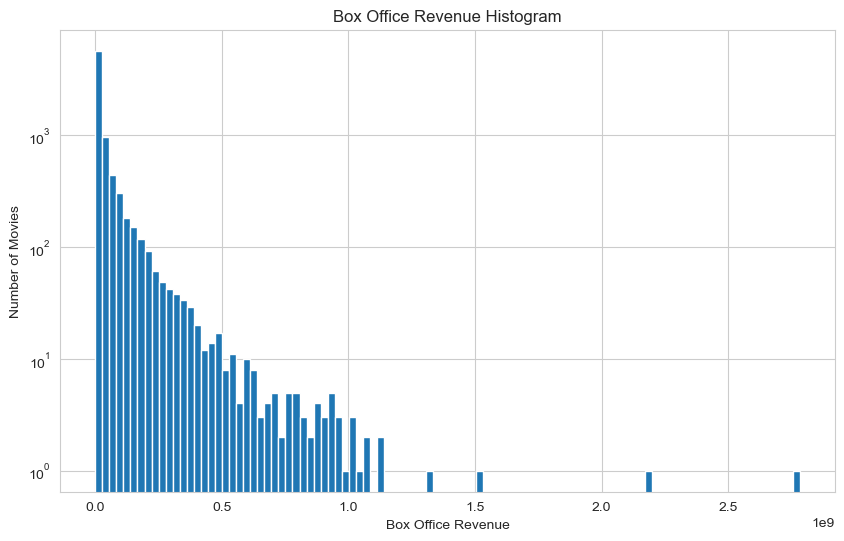

In [8]:
#plot box office revenue with a log scale
plt.figure(figsize=(10, 6))
plt.hist(movie_metadata_df['movie_box_office_revenue'], bins=100, log=True)
plt.xlabel('Box Office Revenue')
plt.ylabel('Number of Movies')
plt.title('Box Office Revenue Histogram')
plt.show()

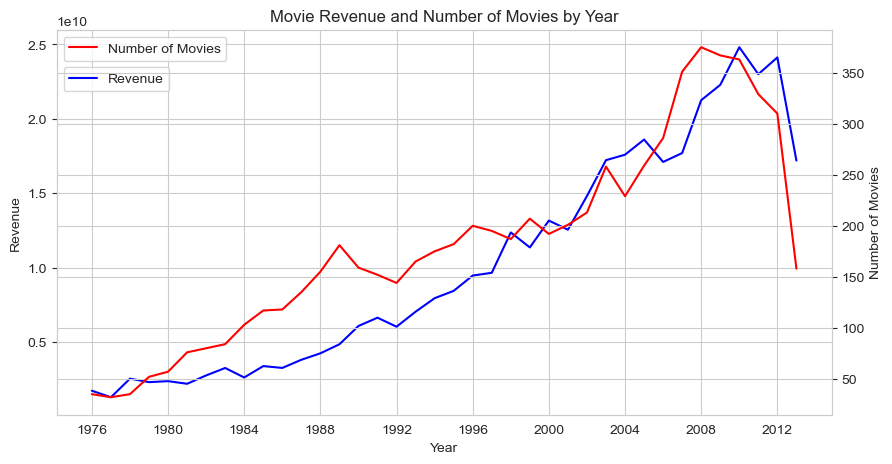

In [9]:
#aggregate movie revenue by year
movie_revenue_by_year = movie_metadata_df.groupby(pd.Grouper(key='movie_release_date', freq='Y'))['movie_box_office_revenue'].sum()
#aggregate number of movies by year ignoring movies with no revenue
movie_with_revenue = movie_metadata_df[movie_metadata_df['movie_box_office_revenue'] > 0]
movie_by_year = movie_with_revenue.groupby(pd.Grouper(key='movie_release_date', freq='Y'))['movie_box_office_revenue'].count()
#plot movie revenue by year
plt.figure(figsize=(10,5))
plt.plot(movie_revenue_by_year.loc['1975':'2012'], color='blue', label='Revenue')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.legend(loc='upper left', bbox_to_anchor=(0, 0.92))
plt.twinx()
plt.plot(movie_by_year.loc['1975':'2012'], color='red', label='Number of Movies')
plt.ylabel('Number of Movies')
plt.title('Movie Revenue and Number of Movies by Year')
plt.legend(loc='upper left')
plt.show()

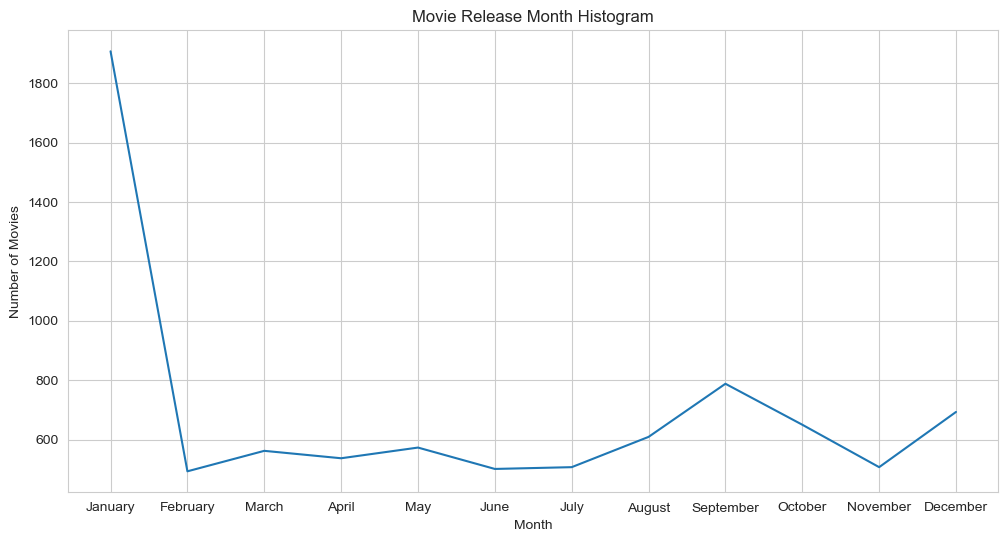

In [10]:
#movies per month ignoring movies with no revenue
movie_per_month = movie_with_revenue.groupby(movie_with_revenue['movie_release_date'].dt.strftime('%m')).count()['freebase_movie_id']
movie_per_month.index = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 
                                'November', 'December']
#plot a histogram of the months with the most movies released
plt.figure(figsize=(12, 6))
plt.plot(movie_per_month)
plt.xlabel('Month')
plt.ylabel('Number of Movies')
plt.title('Movie Release Month Histogram')
plt.show()

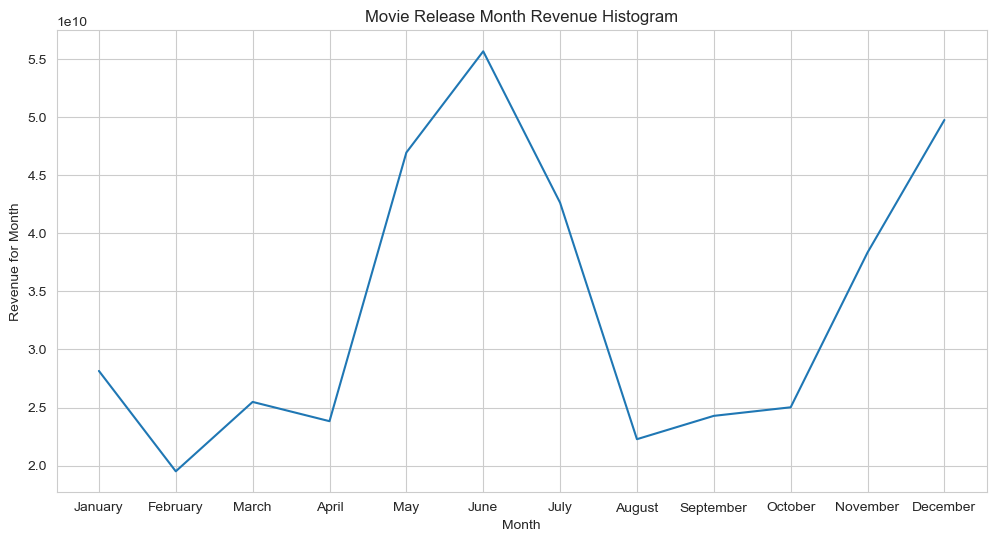

In [11]:
#aggregate movie revenue by month in 12 bins
movie_revenue_by_month = movie_metadata_df.groupby(movie_metadata_df['movie_release_date'].dt.strftime('%m'))['movie_box_office_revenue'].sum()
#change index to month names
movie_revenue_by_month.index = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 
                                'November', 'December']
#plot histogram of movie revenue by month
plt.figure(figsize=(12, 6))
plt.plot(movie_revenue_by_month)
plt.xlabel('Month')
plt.ylabel('Revenue for Month')
plt.title('Movie Release Month Revenue Histogram')
plt.show()

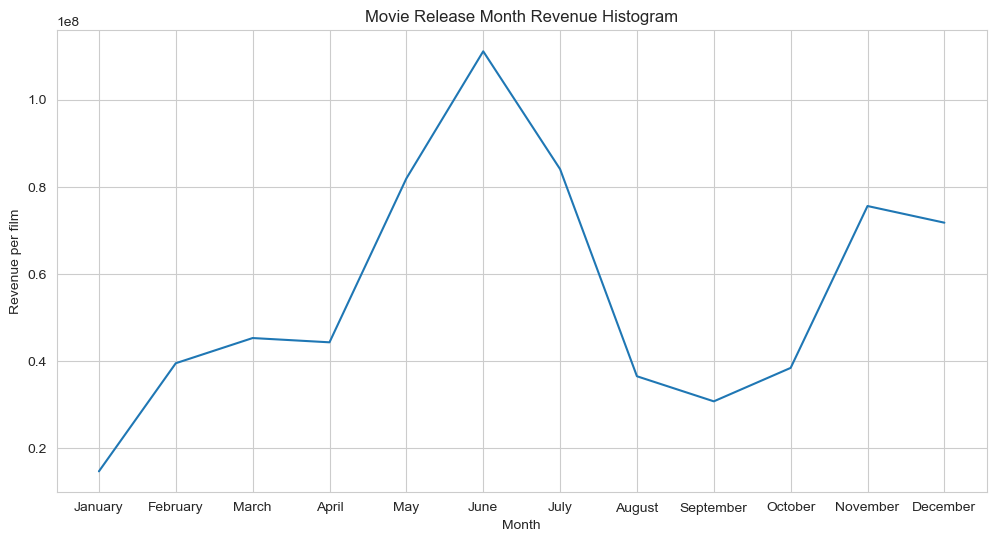

In [12]:
#plot month that are the most profitable
plt.figure(figsize=(12, 6))
plt.plot(movie_revenue_by_month/movie_per_month)
plt.xlabel('Month')
plt.ylabel('Revenue per film')
plt.title('Movie Release Month Revenue Histogram')
plt.show()

In [13]:
#5 longest movies
movie_metadata_df.sort_values(by=['movie_runtime'], ascending=False).head(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
62962,32441022,/m/0gyr803,Modern Times Forever,NaT,NaN,14400.0,{},{},"{""/m/0jtdp"": ""Documentary""}"
71100,25345684,/m/09gqhh3,Cinématon,2011-01-01,NaN,9360.0,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France""}","{""/m/0424mc"": ""Experimental film"", ""/m/0jtdp"":..."
21733,14545195,/m/03qcghh,Matrjoschka,2006-04-23,NaN,5700.0,{},"{""/m/0345h"": ""Germany""}","{""/m/0219x_"": ""Indie"", ""/m/0jtdp"": ""Documentary""}"
46666,884435,/m/03lmv2,The Cure for Insomnia,1987-01-31,NaN,5220.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4lw"": ""Art film""}"
16316,21689271,/m/05q4cg8,Paradise in Harlem,NaT,NaN,5100.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


In [14]:
#5 longest movies excluding movies longer than 240 minutes (4 hours)
movie_metadata_df[movie_metadata_df['movie_runtime'] < 240].sort_values(by=['movie_runtime'], ascending=False).head(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
14019,2648908,/m/07v87d,Jane Eyre,1983-10-09,NaN,239.0,"{""/m/064_8sq"": ""French Language"", ""/m/02h40lc""...","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/07s9rl0"": ""..."
24340,9498765,/m/028cfq0,The Iceman Cometh,1973-11-10,NaN,239.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
54237,6038556,/m/0flx6r,An Evening with Kevin Smith 2: Evening Harder,2006-01-01,NaN,239.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0jtdp"": ""Documentary""}"
20440,417004,/m/025w1d,The Falls,1980-01-01,NaN,239.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/06n90"": ""Science Fiction"", ""/m/0219x_"": ""..."
20657,101398,/m/0prh7,Hamlet,1996-12-25,4708156.0,238.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/04xvh5"": ""Costume drama"", ""/m/04xvlr"": ""P..."


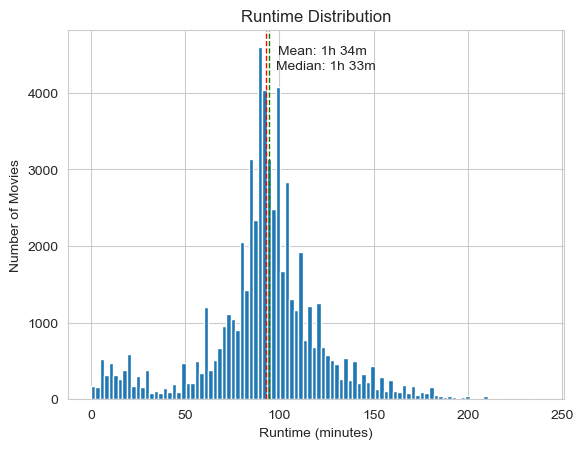

In [15]:
#plot runtime distribution with median and mean
plt.hist(movie_metadata_df[movie_metadata_df['movie_runtime'] < 240]['movie_runtime'], bins=100)
plt.axvline(movie_metadata_df['movie_runtime'].median(), color='red', linestyle='dashed', linewidth=1)
plt.text(movie_metadata_df['movie_runtime'].median() + 5, 4300, 'Median: ' + str(int(movie_metadata_df['movie_runtime'].median()/60)) + 'h ' + str(int(movie_metadata_df['movie_runtime'].median()%60)) + 'm')
plt.axvline(movie_metadata_df['movie_runtime'].mean(), color='green', linestyle='dashed', linewidth=1)
plt.text(movie_metadata_df['movie_runtime'].mean() + 5, 4500, 'Mean: ' + str(int(movie_metadata_df['movie_runtime'].mean()/60)) + 'h ' + str(int(movie_metadata_df['movie_runtime'].mean()%60)) + 'm')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Number of Movies')
plt.title('Runtime Distribution')
plt.show()

In [16]:
#5 shortest movies
movie_metadata_df.sort_values(by=['movie_runtime'], ascending=True).head(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
42478,786716,/m/03c6bq,Dickson Experimental Sound Film,1894-01-01,NaN,0.000000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film""}"
57963,1082508,/m/044ggd,Roundhay Garden Scene,1888-01-01,NaN,0.030000,"{""/m/06ppq"": ""Silent film""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
55686,26044155,/m/0b6f62m,Sallie Gardner at a Gallop,NaT,NaN,0.050000,"{""/m/06ppq"": ""Silent film""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
25984,644824,/m/02_1qn,Dickson Greeting,1891-01-01,NaN,0.050000,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/0219x_"": ""Indie""}"
7486,32175981,/m/0gy0t95,Men Boxing,1891-01-01,NaN,0.083333,"{""/m/06ppq"": ""Silent film""}",{},"{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."


In [17]:
#read text file and add headers
plot_summaries_df = pd.read_csv('data/MovieSummaries/plot_summaries.txt', sep='\t', header=None, 
                names=['wiki_movie_id', 
                        'plot_summary'])
#remove any {{ }} from the plot summary text
plot_summaries_df['plot_summary'] = plot_summaries_df['plot_summary'].str.replace(r'\{\{.*?\}\}', '', regex=True)
plot_summaries_df.head(10)

,wiki_movie_id,plot_summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
5,5272176,The president is on his way to give a speech. ...
6,1952976,"The film opens in 1974, as a young girl, Dahl..."
7,24225279,"The story begins with Hannah, a young Jewish t..."
8,2462689,Infuriated at being told to write one final co...
9,20532852,A line of people drool at the window of the s...


In [18]:
#read text file and add headers, name.clusters.txt
name_clusters_df = pd.read_csv('data/MovieSummaries/name.clusters.txt', sep='\t', header=None, 
                names=['character_name', 
                        'freebase_character_actor_map_id'])
name_clusters_df.head(10)

,character_name,freebase_character_actor_map_id
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn
5,Josh Framm,/m/0jt3p3
6,Josh Framm,/m/0jt3t3
7,Caspian X,/m/0646flc
8,Caspian X,/m/02vd12n
9,Apostle Peter,/m/02vd6_v


In [19]:
#read text file and add headers
character_metadata_df = pd.read_csv('data/MovieSummaries/character.metadata.tsv', sep='\t', header=None, 
                names=['wiki_movie_id',
                        'freebase_movie_id',
                        'movie_release_date',
                        'character_name',
                        'actor_date_of_birth',
                        'actor_gender',
                        'actor_height',
                        'actor_ethnicity',
                        'actor_name',
                        'actor_age_at_movie_release',
                        'freebase_character_actor_map_id',
                        'freebase_character_id',
                        'freebase_actor_id'])
character_metadata_df.head(10)

,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
5,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
6,975900,/m/03vyhn,2001-08-24,Whitlock,1945-08-02,F,1.753,NaN,Joanna Cassidy,56.0,/m/02vd6kw,/m/0bgchmx,/m/06lj1m
7,975900,/m/03vyhn,2001-08-24,Big Daddy Mars,NaN,M,NaN,NaN,Richard Cetrone,NaN,/m/0bgchsy,/m/0bgcht0,/m/0bgcht7
8,975900,/m/03vyhn,2001-08-24,Michael Descanso,1971-03-20,M,1.892,NaN,Liam Waite,30.0,/m/03jqhb0,/m/0bgchs4,/m/0ks8b0
9,975900,/m/03vyhn,2001-08-24,Uno,NaN,M,NaN,NaN,Duane Davis,NaN,/m/0bgchtj,/m/0bgchtm,/m/03nrwdy


In [20]:
#extract the actor ethnicity into a Series from the character metadata removing duplicates
actor_ethnicity_series = character_metadata_df["actor_ethnicity"].drop_duplicates().dropna().reset_index(drop=True)
actor_ethnicity_series.head(10)

0    /m/044038p
1       /m/0x67
2     /m/064b9n
3      /m/041rx
4     /m/033tf_
5     /m/04gfy7
6     /m/0222qb
7     /m/01qhm_
8    /m/0dryh9k
9     /m/048sp5
Name: actor_ethnicity, dtype: object

In [21]:
def get_wikidata_id(freebase_id):
  sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
  query = f"""
  SELECT ?article ?label
  WHERE 
  {{
    ?article schema:about ?item;
        schema:isPartOf <https://en.wikipedia.org/> .
    ?item wdt:P646 "{freebase_id}";
          rdfs:label ?label.
    FILTER(LANG(?label) = "en") # Optional: Filter by English labels
  }}
  """
  sparql.setQuery(query)
  sparql.setReturnFormat(JSON)
  
  try:
      results = sparql.query().convert()
      if 'results' in results and 'bindings' in results['results'] and len(results['results']['bindings']) > 0:
          return results['results']['bindings'][0]['label']['value']
  except Exception as e:
      print(f"Error: {e}")
      time.sleep(20)
      return get_wikidata_id(freebase_id)
  
  return None

In [22]:
#create a dataframe from the results of the sparql query from every element in actor_ethnicity_series
transformed_values = [get_wikidata_id(value) for value in actor_ethnicity_series]

Error: HTTP Error 429: Too Many Requests


In [30]:
data = {'ethnicity_id': actor_ethnicity_series, 'ethnicity_name': transformed_values}
df = pd.DataFrame(data)
#print all ethnicities in the dataframe
dropna_df = df.dropna()

dropna_df




,ethnicity_id,ethnicity_name
1,/m/0x67,African Americans
2,/m/064b9n,Omaha people
3,/m/041rx,Jewish people
4,/m/033tf_,Irish Americans
5,/m/04gfy7,Indian Americans
...,...,...
474,/m/09r2kh,peoples of the Caucasus
475,/m/02ry8mk,Sierra Leone Creole people
476,/m/029q52,Georgians
477,/m/026d074,Goans


In [ ]:
#read text file and add headers
tvtropes_clusters_df = pd.read_csv('data/MovieSummaries/tvtropes.clusters.txt', sep='\t', header=None, names=['character_type', 'data_dict'])
#transform second column to columns
tvtropes_clusters_df['data_dict'] = tvtropes_clusters_df['data_dict'].apply(json.loads)
tvtropes_clusters_df = pd.concat([tvtropes_clusters_df.drop(['data_dict'], axis=1), tvtropes_clusters_df['data_dict'].apply(pd.Series)], axis=1)
#rename columns
tvtropes_clusters_df.columns = ['character_type', 'character_name', 'movie_name', 'freebase_character_actor_map_id', 'actor_name']
tvtropes_clusters_df.head(10)

,character_type,character_name,movie_name,freebase_character_actor_map_id,actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader
5,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Kingdom of the Crystal S...,/m/0jzx78,Harrison Ford
6,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Raiders of the Lost Ark,/m/0k294p,Harrison Ford
7,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Temple of Doom,/m/0jzx9b,Harrison Ford
8,adventurer_archaeologist,Evelyn Carnahan-O'Connell,The Mummy,/m/0k5yzc,Rachel Weisz
9,arrogant_kungfu_guy,Han,Enter the Dragon,/m/02vd8hn,Shih Kien


In [ ]:
#characters that have been played by multiple actors
character_metadata_df[character_metadata_df['character_name'].duplicated(keep=False)].sort_values(by=['character_name'])

,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
323415,7950950,/m/026l5ym,1942-02-20,'2-Gun' Gertie Baxter,1912-05-29,F,1.63,NaN,Iris Adrian,29.0,/m/06plhhz,/m/06plhcj,/m/049wny
323755,198061,/m/01c46q,1927-12-27,'2-Gun' Gertie Baxter,NaN,NaN,NaN,NaN,Viola Louie,NaN,/m/06plq7q,/m/06plhcj,/m/06plq7v
172057,747689,/m/037_84,1979-03-14,'3-5-0-0' Soloist,1945-10-29,F,NaN,/m/0x67,Melba Moore,33.0,/m/0cg6hqj,/m/0h5rdnt,/m/08rgr4
172072,747689,/m/037_84,1979-03-14,'3-5-0-0' Soloist,1950-06-05,M,NaN,NaN,Ronnie Dyson,28.0,/m/0gy_y5r,/m/0h5rdn3,/m/01p27qd
401548,25298252,/m/097pj24,1993-12-12,'Baby' Louise,1982-07-24,F,1.60,/m/07hwkr,Elisabeth Moss,11.0,/m/0h2cmv_,/m/0c0lv8d,/m/08pth9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450649,12476867,/m/02w7zz8,2002,NaN,NaN,NaN,NaN,NaN,Ariel Bastian,NaN,/m/0gdkb51,NaN,/m/0gdkb55
450650,12476867,/m/02w7zz8,2002,NaN,NaN,NaN,NaN,NaN,Jared Van Snellenberg,NaN,/m/0gdndlw,NaN,/m/0gdmxzn
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.73,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm
